In [1]:
import torch
import torch.nn as nn
import torchvision.models.detection.rpn as rpn
import torchvision.models.detection.image_list as image_list
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Retina display for figure
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# display all outputs instead of last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from torchvision.models.detection.backbone_utils import  resnet_fpn_backbone
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [3]:
# some helper functions
def show_features(features, idx, save=False):
    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((img.size[0]//4, img.size[1]//4)), alpha=0.9)
    axes[0,1].imshow(features['0'][0, idx, :, :].detach().numpy(), cmap='jet')#, alpha=0.5)
    axes[0,1].set_title('P2')

    axes[0,2].imshow(features['1'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[0,2].set_title('P3')
    
    axes[1,0].imshow(features['2'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,0].set_title('P4')
    
    axes[1,1].imshow(features['3'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,1].set_title('P5')
    
    axes[1,2].imshow(features['pool'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,2].set_title('P6')

    if save:
        plt.savefig('feature_results.png', bbox_inches='tight')


# helper function
def process_obj(objectness):
    # import numpy as np

    # objectness = objectness.detach().numpy()
    
    # # sigmod to [0,1]
    # objectness = 1.0/ (1 + np.exp(-1*objectness))
    # # scale to [0, 255]
    # objectness = np.round(objectness*255) 
    
    # apply sigmoid
    objectness = torch.sigmoid(objectness)
    # scale to [0,255]
    objectness = torch.round(objectness*255)
    # convert to numpy
    objectness = objectness.detach().numpy()

    return objectness

# show the heatmaps of objectness overlaid to image
def show_objectness(img, objectness, idx, save=False):
    # same extent needs to be defined for different images
    # extent = 0, objectness[0][0, idx, :, :].shape[1], 0, objectness[0][0, idx, :, :].shape[0]
    # (width, height) = (img.width // 4, img.height // 4)

    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,1].imshow(objectness[0][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,1].set_title('objectness on P2')

    # axes[0,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,2].imshow(objectness[1][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,2].set_title('objectness on P3')
    
    # axes[1,0].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,0].imshow(objectness[2][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,0].set_title('objectness on P4')
    
    # axes[1,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,1].imshow(objectness[3][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,1].set_title('objectness on P5')
    
    # axes[1,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,2].imshow(objectness[4][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,2].set_title('objectness on P6')

    if save:
        plt.savefig('objectness_results.png', bbox_inches='tight')

## Get the pre-trained model from torchvision

In [4]:
# Get the backbone and build RPN from it
# it seems some missing construction from the final results
#
# backbone = resnet_fpn_backbone('resnet50', pretrained=True)

# out_channels = backbone.out_channels

# anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
# aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)

# rpn_anchor_generator = rpn.AnchorGenerator(anchor_sizes, aspect_ratios)

# net = rpn.RPNHead(out_channels, rpn_anchor_generator.num_anchors_per_location()[0])

In [5]:
# Get the whole FRCNN model

model = fasterrcnn_resnet50_fpn(pretrained=False)
model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn_coco-258fb6c6.pth'))

model.eval()

<All keys matched successfully>

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

In [6]:
# Reconstruct the modules required for objectness heatmap

# feature_net = nn.Sequential(*list(model.children())[:-2])
feature_net = nn.ModuleList(list(model.children())[1:3])
feature_net.eval()

ModuleList(
  (0): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
        (1): Bottleneck(
          (conv1

### Find an image for test

In [7]:
# ! wget -O test.jpeg https://miro.medium.com/max/1744/1*EYFejGUjvjPcc4PZTwoufw.jpeg 

(872, 586)

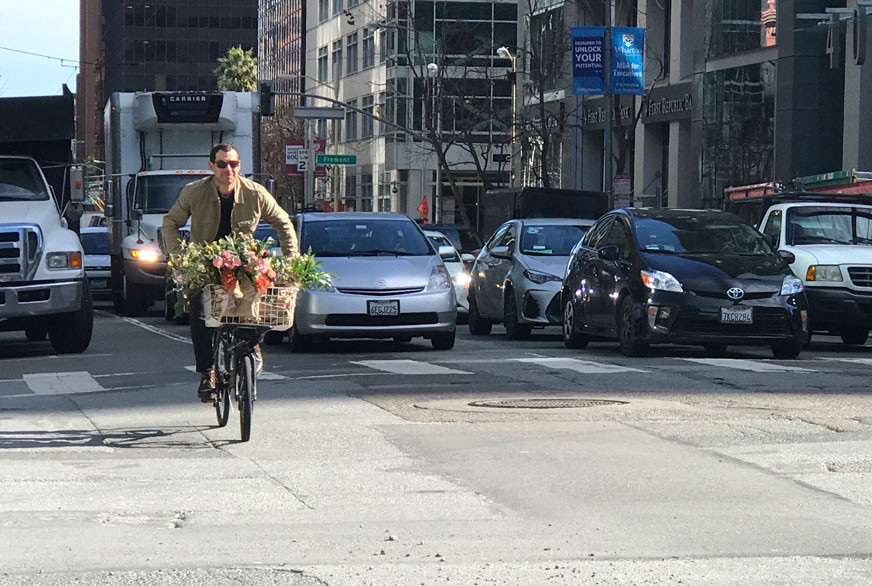

In [8]:
from PIL import Image
img = Image.open('test.jpeg')
# img = Image.open('test_mrcnn_2.jpg')
img.size
img

In [9]:
# prepare for the input 

transform = T.Compose([T.ToTensor()])
input_im = transform(img)
# input_im = torch.from_numpy(img/255).float()

# input_im = input_im.unsqueeze_(0)
# features = backbone(input_im)


input_im.shape

input_im_tensor = torch.unsqueeze(input_im, 0)

input_im_tensor.shape

torch.Size([3, 586, 872])

torch.Size([1, 3, 586, 872])

### Obtain the features

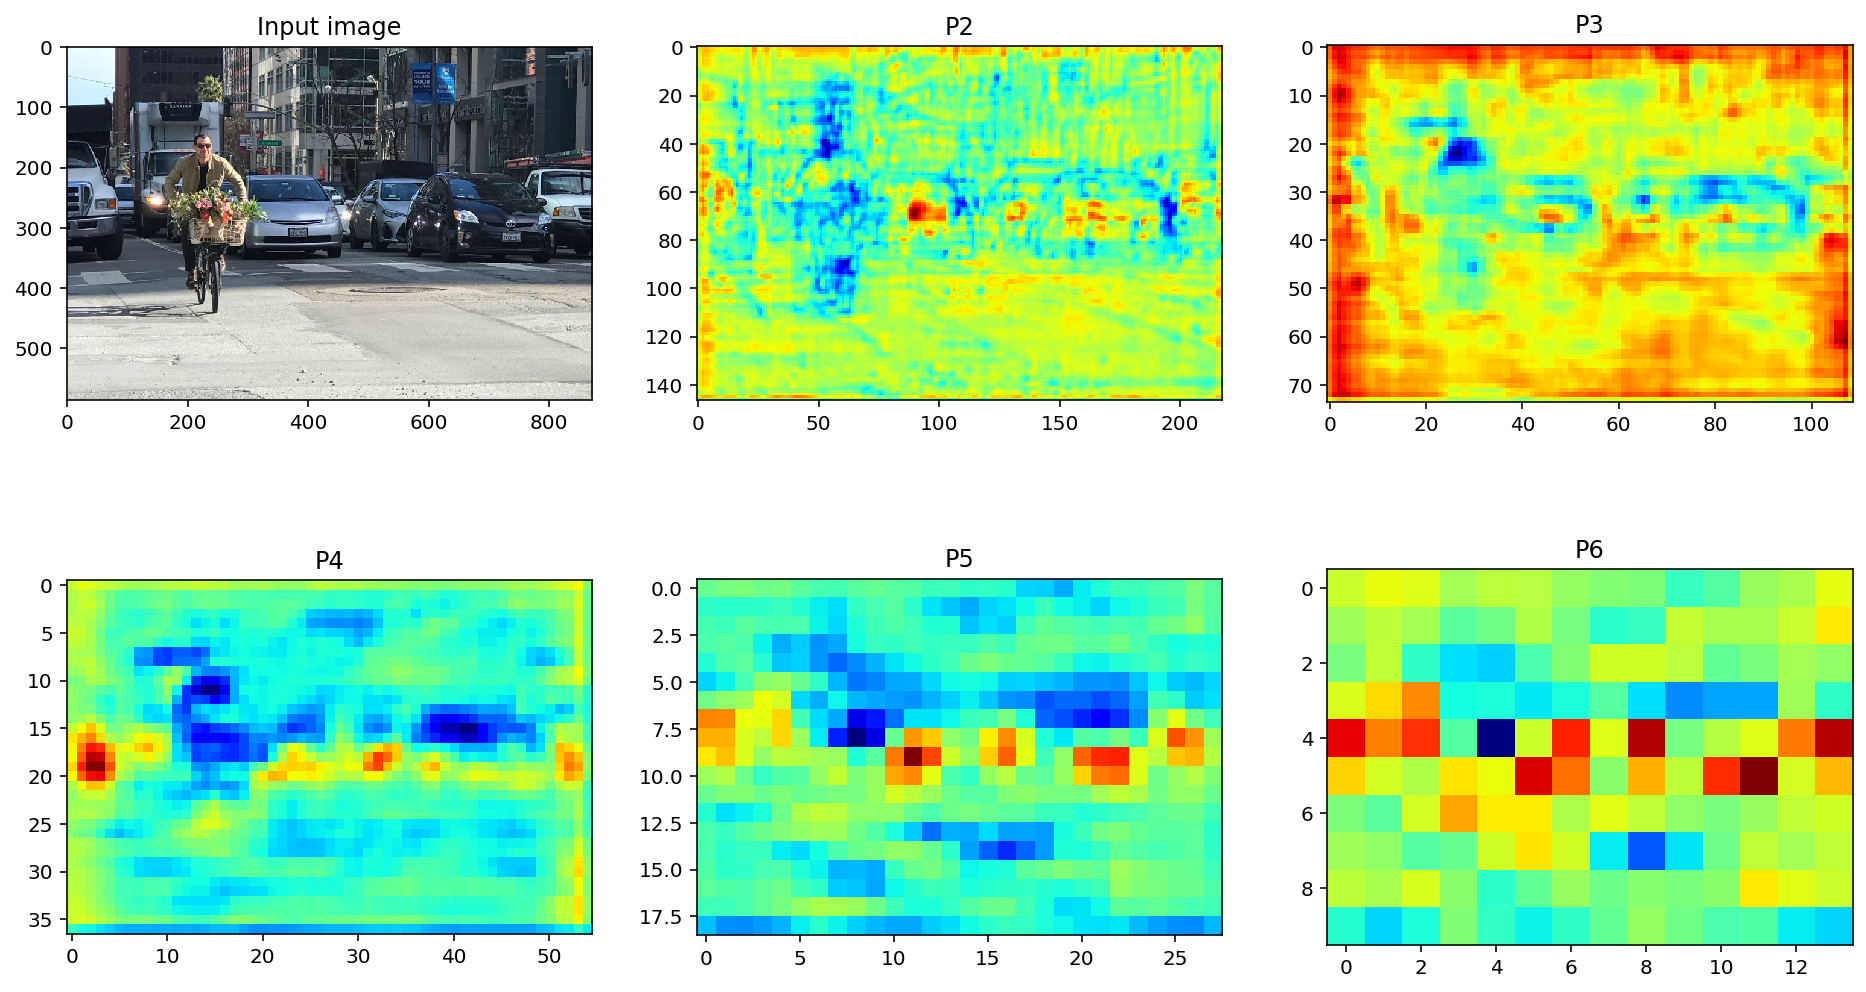

In [10]:
# Get the feature maps 

feat_test = feature_net[0](input_im_tensor)
show_features(feat_test,0, True)

### Obtain the objectness

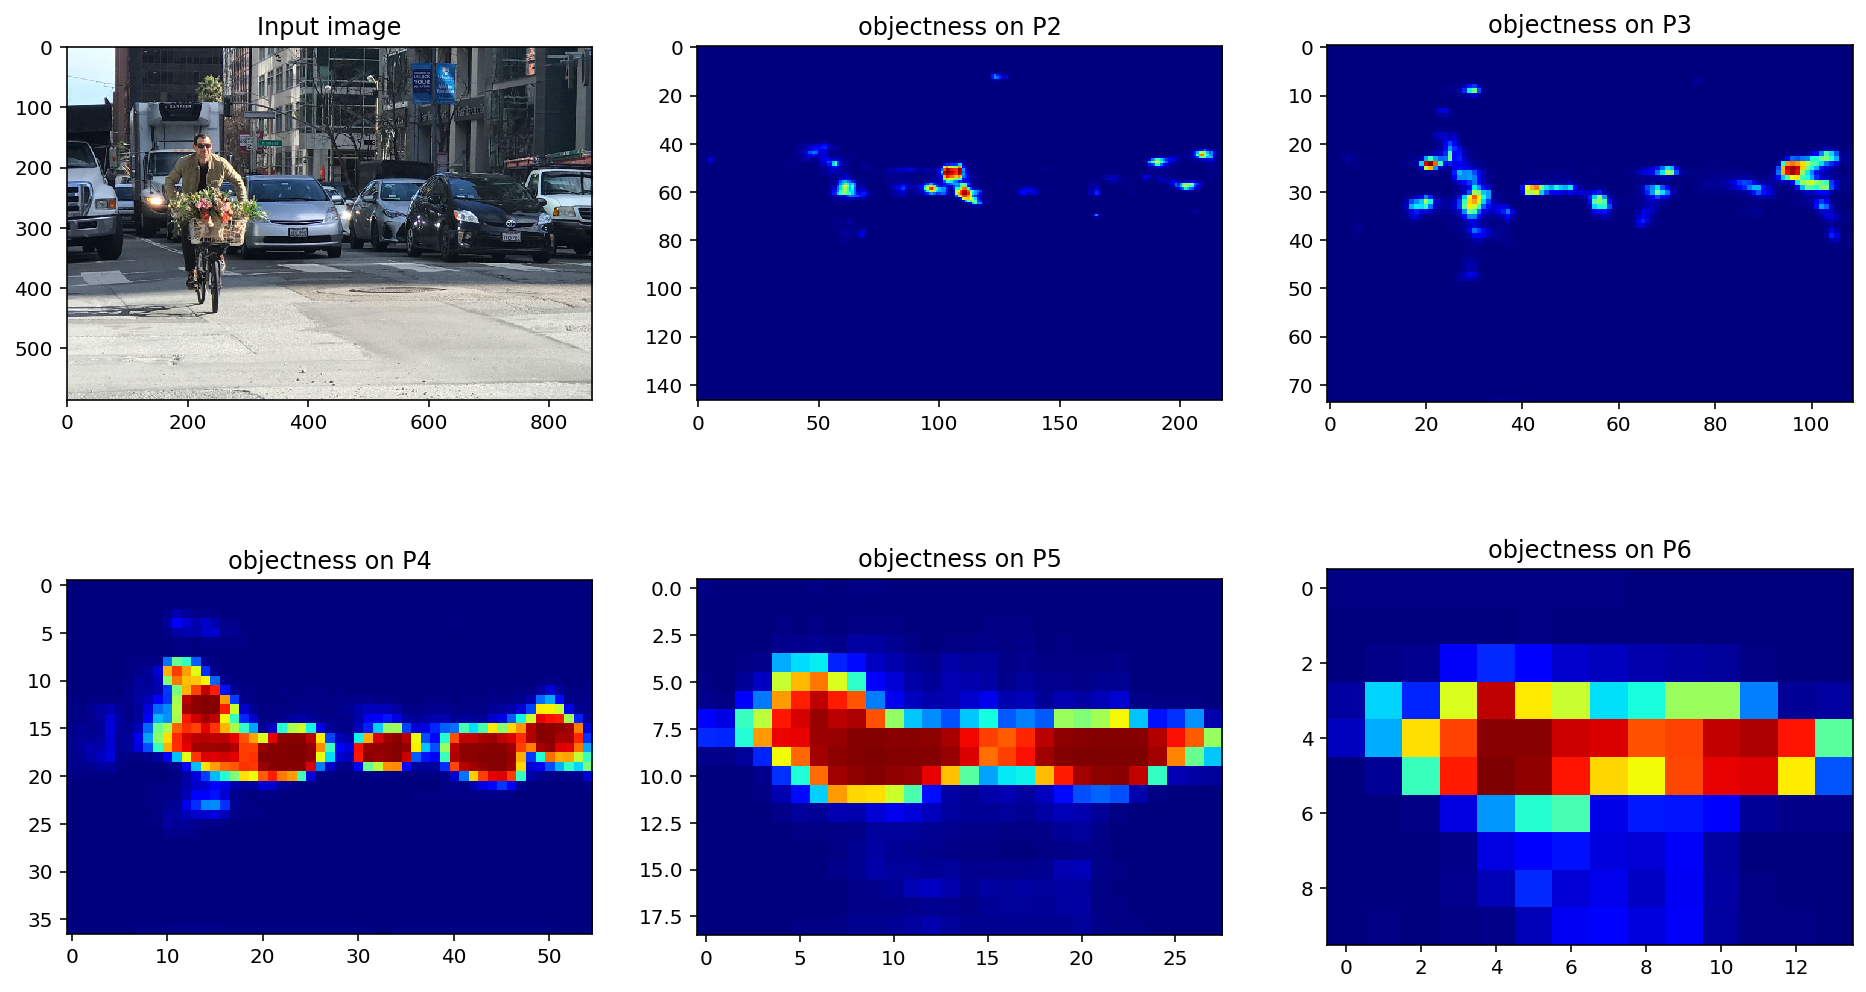

In [11]:
# Get the objectness heat maps
# feature_net[1] includes RPNHead which is essential
obj_test,_ = feature_net[1].head(feat_test.values())

# post processing
obj_test = [process_obj(obj) for obj in obj_test]

show_objectness(img, obj_test, 0, True)

In [ ]:
# put together to save the results
results = {}
results['Features'] = feat_test
results['Objectness'] = obj_test

results.keys()

### End

In [ ]:
import cv2

src_img = cv2.imread('test.jpeg')
img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img/255.).permute(2,0,1).float()

type(img_tensor)
img_tensor.shape

In [ ]:
model.transform([input_im])

In [ ]:
# net1 = nn.Sequential(*list(model.transform.children()))
net1 = model.transform
out = net1([input_im])
# out = model.backbone(out)
out

In [ ]:
len(out)

out[0].tensors.shape

In [ ]:
out2 = net2(out[0].tensors)

show_features(out2, 0)

In [ ]:
out3, _ = model.rpn.head(out2.values())
out3_list = [process_obj(out) for out in out3]

show_objectness(img, out3_list, 0)

In [ ]:
net2 = model.backbone

out2 = net2(out[0].unsqueeze_(0))

In [ ]:
# test for input
out_test = net2(input_im_tensor)
show_features(out_test, 0)

In [ ]:
show_features(out2,  0)

In [ ]:
out2.values()

In [ ]:
# net3 = model.rpn()
out3, _ = model.rpn.head(out2.values())

# out3,_ = net3(out2.values())

In [ ]:
out3_list = [process_obj(out) for out in out3]

show_objectness(img, out3_list, 0)

In [ ]:
# type(input_im)
feature_net.eval()
features = feature_net([img_tensor])

for f in features.values():
    print(f.size())

features.keys()

### Show the feature maps with original image

In [ ]:
def show_features(features, idx):
    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((img.size[0]//4, img.size[1]//4)), alpha=0.9)
    axes[0,1].imshow(features['0'][0, idx, :, :].detach().numpy(), cmap='jet')#, alpha=0.5)
    axes[0,1].set_title('P2')

    axes[0,2].imshow(features['1'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[0,2].set_title('P3')
    
    axes[1,0].imshow(features['2'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,0].set_title('P4')
    
    axes[1,1].imshow(features['3'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,1].set_title('P5')
    
    axes[1,2].imshow(features['pool'][0, idx, :, :].detach().numpy(), cmap='jet')
    axes[1,2].set_title('P6')

In [ ]:
show_features(features, 127)

## Get the objectness heatmap

> Figure 4. Visualization of objectness maps. Sigmoid function has been applied to the objectness_logits map. \
**The objectness maps for 1:1 anchor** are resized to the P2 feature map size and overlaid on the original image.

### Method mentioned by author:
>I just insert the following features here to save the objectness heatmap.
1. apply sigmoid and scale the tensor range to 0–255
2. choose a map from the tensor
3. convert it to numpy array (uint8)
4. save it as an image file (or directly visualize it using matplotlib)
> 
>If you use proper weights and proper input image, it should work :)

In [ ]:
# helper function
def process_obj(objectness):
    # import numpy as np

    # objectness = objectness.detach().numpy()
    
    # # sigmod to [0,1]
    # objectness = 1.0/ (1 + np.exp(-1*objectness))
    # # scale to [0, 255]
    # objectness = np.round(objectness*255) 
    
    # apply sigmoid
    objectness = torch.sigmoid(objectness)
    # scale to [0,255]
    objectness = torch.round(objectness*255)
    # convert to numpy
    objectness = objectness.detach().numpy()

    return objectness

# show the heatmaps of objectness overlaid to image
def show_objectness(img, objectness, idx):
    # same extent needs to be defined for different images
    # extent = 0, objectness[0][0, idx, :, :].shape[1], 0, objectness[0][0, idx, :, :].shape[0]
    # (width, height) = (img.width // 4, img.height // 4)

    fig, axes = plt.subplots(2, 3, figsize=(16,9))

    axes[0,0].imshow(img)
    axes[0,0].set_title('Input image')

    # axes[0,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,1].imshow(objectness[0][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,1].set_title('objectness on P2')

    # axes[0,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[0,2].imshow(objectness[1][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[0,2].set_title('objectness on P3')
    
    # axes[1,0].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,0].imshow(objectness[2][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,0].set_title('objectness on P4')
    
    # axes[1,1].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,1].imshow(objectness[3][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,1].set_title('objectness on P5')
    
    # axes[1,2].imshow(img.resize((width, height)),  cmap='gray')#, extent=extent)
    axes[1,2].imshow(objectness[4][0, idx, :, :], cmap='jet', alpha=1.0)#, extent=extent)
    axes[1,2].set_title('objectness on P6')

In [ ]:
# get objectness from RPN head
objectness, _  = net(list(features.values()))

# objectness, pred_bbox_deltas = rpn.concat_box_prediction_layers(objectness, pred_bbox_deltas)

len(objectness)

In [ ]:
# upsampling || resizing into P2 shape
# use torch.nn.functional.interpolate

#TODO overlaid image is not as expected
# upsampling might be improved
import torch.nn.functional as F

test = objectness.copy()
for i in range(len(objectness)):
    if i > 0:
        test[i] = F.interpolate(objectness[i], scale_factor=2**(i))

In [ ]:
test_out = [process_obj(t) for t in test]

In [ ]:
test_out[1].shape

In [ ]:
show_objectness(img, test_out, 2)

In [ ]:
# apply process fct
out = [process_obj(obj) for obj in objectness]

print(out[0].max())
print(out[0].min())

out[0][0,0,:,:].shape

In [ ]:
out_resized = out[1][0, 2, :, :]
out_resized.shape

In [ ]:
out[0][0, 2, :, :].shape

In [ ]:
# use b.resize will not fill with repeated values
b = out_resized.copy()
b.resize(107, 160)

In [ ]:
# resize into P2 dimension
# use np.resize
# TODO results are not as expected
# np.resize will fill the repeated values
for i in range(len(out)):
    if i > 0:
        out[i] = np.resize(out[i], (out[0].shape))

In [ ]:
plt.imshow(b, cmap='jet')
# plt.imshow(out[1][0, 2, :, :], cmap='jet')

In [ ]:
show_objectness(img, out, 2)

In [ ]:
import numpy as np

obj_sgm = torch.sigmoid(objectness[0])
print(obj_sgm.max()*255)
print(obj_sgm.min()*255)
obj_sgm = 1.0 / (1 + np.exp(-1*objectness[0].detach().numpy() ))
print(obj_sgm.max()*255)
print(obj_sgm.min()*255)

In [ ]:
import torch
import torchvision.models as models
import torchvision.models.detection.backbone_utils as backbone_utils
 
backbone = models.resnet50(pretrained=True)
return_layers = {'layer1': 0, 'layer2': 1, 'layer3': 2, 'layer4': 3}
in_channels_list = [256,512,1024,2048]
out_channels = 256
resnet_with_fpn = backbone_utils.BackboneWithFPN(backbone,
    return_layers,in_channels_list,out_channels)

resnet_with_fpn

In [ ]:
# from torchvision import transforms as T

# img = img.resize((640,640))

# transform = T.Compose([T.ToTensor()])
# img = transform(img)

features = resnet_with_fpn(input_im)
features

In [ ]:
for f in features.values():
    print(f.shape)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16,10))

i = 1
axes[0,0].imshow(img)
axes[0,1].imshow(features[0][0, i, :, :].detach().numpy())
axes[0,2].imshow(features[1][0, i, :, :].detach().numpy())
axes[1,0].imshow(features[2][0, i, :, :].detach().numpy())
axes[1,1].imshow(features[3][0, i, :, :].detach().numpy())
axes[1,2].imshow(features['pool'][0, i, :, :].detach().numpy())